# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import warnings
import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
import category_encoders as ce

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
#тип автомобильного кузова
data['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [7]:
#тип коробки передач
data['Gearbox'].value_counts(dropna=False)

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

In [8]:
#модель автомобиля
data['Model'].value_counts(dropna=False)

golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

In [9]:
#тип топлива
data['FuelType'].value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [10]:
#была машина в ремонте или нет
data['Repaired'].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: Repaired, dtype: int64

В 5 столбцах были найдены пропуски, все они относятся к категориальным признакам. Возможно, причиной могла послужить невнимательность или же неосведомленность пользователей «Не бит, не крашен». 

Так как значения NaN могут привести к некорректным результатам при работе с данными, поставим своего рода //заглушку со значением - indefined 

In [11]:
#обработка пропусков
data = data.fillna('indefined')
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Всё, пропуски обработаны, двигаемся дальше...

Проверим данные на наличие дублей

In [12]:
data.duplicated().sum()

4

In [13]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

<AxesSubplot:>

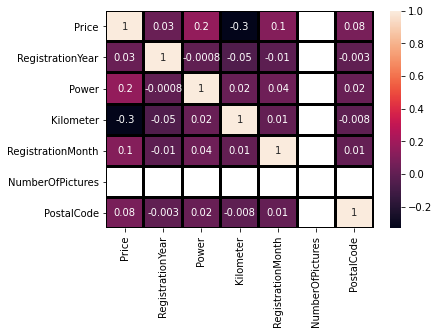

In [14]:
sns.heatmap(
    data.corr(), 
    annot = True, 
    fmt='.1g', 
    linewidths=2, 
    linecolor='black')

In [15]:
data['NumberOfPictures'].value_counts()

0    354365
Name: NumberOfPictures, dtype: int64

Целевой признак - Price. 
Нужно спрогнозровать рыночную стоимость автомобиля. Среди данных о технических характеристиках, комплектации и ценах других автомобилей, имеются неинформативные признаки для прогноза:
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* DateCrawled — дата скачивания анкеты из базы
* DateCreated — дата создания анкеты
* RegistrationMonth — месяц регистрации автомобиля
* LastSeen — дата последней активности пользователя
* NumberOfPictures — количество фотографий автомобиля

От этих признаков мы избавимся. NumberOfPictures содержит в себе только одно единственное значение: 0. Оставшиеся признаки никак не влияют на формирование цены.

In [16]:
data = data.drop(['PostalCode', 'DateCrawled', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth'], axis=1)

In [17]:
data = data.drop(['DateCreated'], axis=1)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       354365 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           354365 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             354365 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          354365 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Неинформативные признаки удалены, далее проверим данные на аномалии 

In [19]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


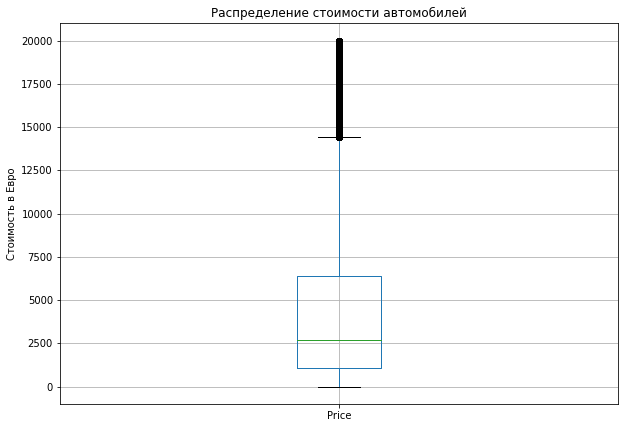

In [20]:
data.boxplot(['Price'],figsize=(10, 7))

plt.title('Распределение стоимости автомобилей')
plt.ylabel('Стоимость в Евро')

plt.show()

На диаграмме размаха можно увидеть что Q2 равен 2.7 тысяч евро. Выбрасы начинаются к отметке ~ 14 т.е. Но для цен автомобилей эти отметки приемлемы. Минимум начинается с отметки 0, обработаем значения так, чтобы прайс начинался с 200 евро

In [21]:
data = data.query('Price > 200')

<div class="alert alert-warning">
<b>Комментарий 👉</b>

(Отвлечение ... что-то менять не надо) Мне это напомнило один известный фильм, где автомобиль за 500 долларов был способен доехать до Сан-Франциско и обратно ))))
</div>

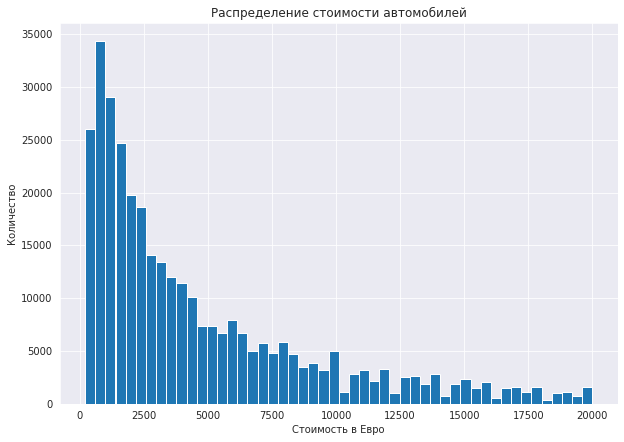

In [22]:
sns.set_style('darkgrid')

data['Price'].hist(bins=50,figsize=(10, 7))

plt.title('Распределение стоимости автомобилей')
plt.xlabel('Стоимость в Евро')
plt.ylabel('Количество')

plt.show()

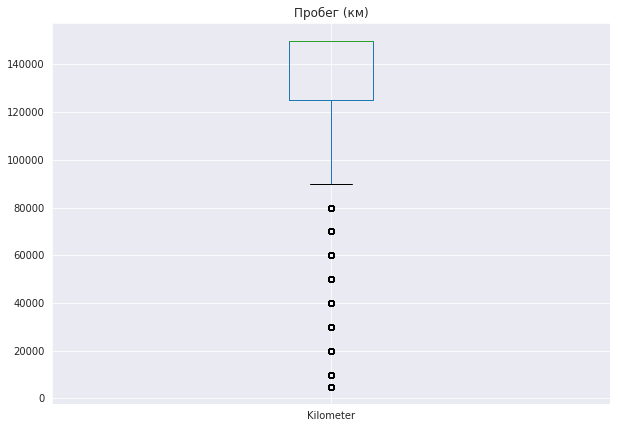

In [23]:
data.boxplot(['Kilometer'],figsize=(10, 7))
plt.title('Пробег (км)')
plt.show()

Занчения признака Kilometer в пределах нормы, не требуют доработки 

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Верно! Пробег я бы тоже не трогал. Тут сложно сказать что выброс, что не выброс. С одной стороны "старая" машина могла большую часть жизни провести в гараже, а с другой стороны, свежий экземпляр накатать в такси сотни тысяч миль.
</div>

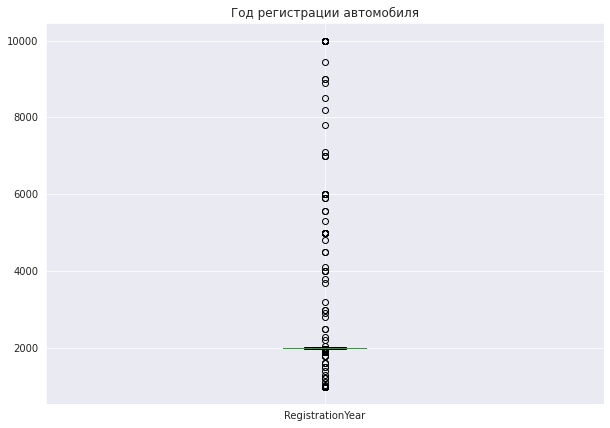

In [24]:
data.boxplot(['RegistrationYear'],figsize=(10, 7))
plt.title('Год регистрации автомобиля')
plt.show()

In [25]:
#срез временного отрезка
data = data.query('RegistrationYear >= 1950 & RegistrationYear <= 2016')

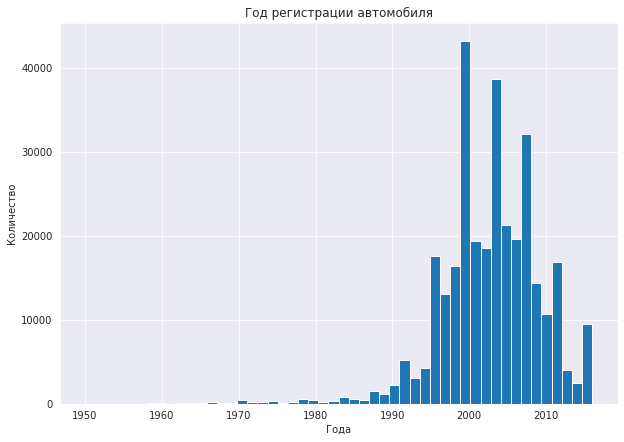

In [26]:
sns.set_style('darkgrid')

data['RegistrationYear'].hist(bins=50,figsize=(10, 7))

plt.title('Год регистрации автомобиля')
plt.xlabel('Года')
plt.ylabel('Количество')

plt.show()

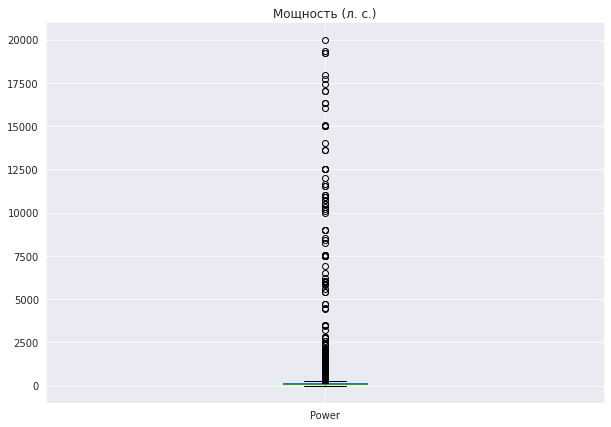

In [27]:
data.boxplot(['Power'],figsize=(10, 7))
plt.title('Мощность (л. с.)')
plt.show()

Современный автомобиль имеет двигатель мощностью как минимум 120 лошадиных сил. Мотору маленького автомобиля достаточно 70 лошадей. Максимальное значение равно 2000 л.с.

Q1 равен 75 л.с. 

Q2 равен 105 л.с.

С учетом этого обработаем признак следующим образом:

In [28]:
#возьмем данные меньше 2000
data = data.query('Power <= 2000')

In [29]:
#заполним 0 медианой
med  = data['Power'].median()
data['Power'] = data['Power'].replace(0, med)

#изменим тип данных на int
data['Power'] = data['Power'].astype('int')

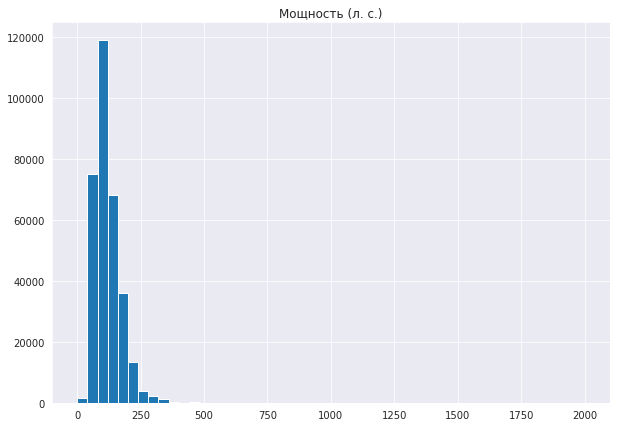

In [30]:
sns.set_style('darkgrid')

data['Power'].hist(bins=50,figsize=(10, 7))

plt.title('Mощность (л. с.)')
plt.show()

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321113 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             321113 non-null  int64 
 1   VehicleType       321113 non-null  object
 2   RegistrationYear  321113 non-null  int64 
 3   Gearbox           321113 non-null  object
 4   Power             321113 non-null  int64 
 5   Model             321113 non-null  object
 6   Kilometer         321113 non-null  int64 
 7   FuelType          321113 non-null  object
 8   Brand             321113 non-null  object
 9   Repaired          321113 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.9+ MB


**ВЫВОД 1:**

На этапе предобработки:
- данные были проверены на наличение пропусков;
- обработаны дубликаты;
- изучены корреляционные зависимости между целевым и обучающими признаками;
- отсечены неинформативные признаки;
- обработы выбросы в данных.

Из 16 начальных признаков, осталось 10:

**object:**
* VehicleType, Gearbox, Model, FuelType, Brand, Repaired

**int64:**
* RegistrationYear, Kilometer, Power, Price


## Обучение моделей

In [32]:
features_train, features_valid, target_train, target_valid = train_test_split(
    data.drop('Price', axis=1), data.Price, test_size=0.5, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [33]:
print('Тренировочная выборка:', features_train.shape)
print('Валидационная выборка:', features_valid.shape)
print('Тестовая выборка:', features_test.shape)
print()
print('Целевой признак тренировочная выборки:', target_train.shape)
print('Целевой признак валидационной выборки:', target_valid.shape)
print('Целевой признак тестовой выборки:', target_test.shape)

Тренировочная выборка: (160556, 9)
Валидационная выборка: (80279, 9)
Тестовая выборка: (80278, 9)

Целевой признак тренировочная выборки: (160556,)
Целевой признак валидационной выборки: (80279,)
Целевой признак тестовой выборки: (80278,)


In [34]:
encoder = ce.TargetEncoder()
encoder.fit(features_train, target_train)

TargetEncoder(cols=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
                    'Repaired'])

In [35]:
features_train_te = encoder.transform(features_train)

In [36]:
features_valid_te = encoder.transform(features_valid)

In [37]:
features_test_te = encoder.transform(features_test)

In [38]:
print('Тренировочная выборка:', features_train_te.shape)
print('Валидационная выборка:', features_valid_te.shape)
print('Тестовая выборка:', features_test_te.shape)

Тренировочная выборка: (160556, 9)
Валидационная выборка: (80279, 9)
Тестовая выборка: (80278, 9)


In [39]:
features_train_te.head(2)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
323518,2836.600384,2006,4204.06543,60,2949.661624,80000,3967.857526,3495.420578,5442.939391
280472,5042.508221,2004,4204.06543,125,2786.631910,150000,3967.857526,3495.420578,5442.939391


In [40]:
features_valid_te.head(2)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
64084,4892.299898,1997,4204.06543,170,6641.925654,150000,3967.857526,6485.572898,5442.939391
332276,5042.508221,2006,4204.06543,140,4668.913811,150000,6752.287716,4661.291102,3000.369102


In [41]:
features_test_te.head(2)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
26269,5042.508221,2012,7119.379511,140,4668.913811,150000,6752.287716,4661.291102,5442.939391
222477,4892.299898,1995,4204.065430,105,3237.784702,90000,3967.857526,2956.335150,2183.939569


У признаков разный масштаб, чтобы избежать ловушки необходимо их стандартизировать. Это можно сделать с StandardScaler()

In [42]:
#Создадим список всех численных признаков
numeric = ['RegistrationYear', 'Kilometer', 'Power']

In [43]:
#Создадим объект этой структуры и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train_te[numeric]) 

StandardScaler()

In [44]:
#Сохраним проеобразование для тренировочный выборки 
features_train_te[numeric] = scaler.transform(features_train_te[numeric])

In [45]:
#Сохраним проеобразование для валидационной выборки
features_valid_te[numeric] = scaler.transform(features_valid_te[numeric])

In [46]:
#Сохраним проеобразование для тестовой выборки
features_test_te[numeric] = scaler.transform(features_test_te[numeric])

**LGBMRegressor**

In [47]:
%%time
start = time.time()

model_LGBM = LGBMRegressor(random_state=12345)
model_LGBM.fit(features_train_te, target_train)

end = time.time()
lgbm_fit = end-start

CPU times: user 3.48 s, sys: 41.7 ms, total: 3.52 s
Wall time: 3.49 s


In [48]:
%%time
start = time.time()

predicted = model_LGBM.predict(features_valid_te)

end = time.time()
lgbm_pred = end-start

CPU times: user 543 ms, sys: 0 ns, total: 543 ms
Wall time: 597 ms


In [49]:
lgbm_rmse = mean_squared_error(target_valid, predicted)**0.5
print("Разница между значениями RMSE =", lgbm_rmse)

Разница между значениями RMSE = 1703.6935412997789


**CatBoostRegressor**

In [50]:
%%time
model_cat = CatBoostRegressor(verbose=False)
parametrs = {
             "depth": [4, 6, 10],
             "iterations": [60]}

CPU times: user 135 µs, sys: 0 ns, total: 135 µs
Wall time: 141 µs


In [51]:
%%time
start = time.time()

grid = GridSearchCV(model_cat, parametrs, cv=5)
model_grid = grid.fit(features_train_te, target_train)

end = time.time()
cat_fit = end-start

print(model_grid.best_params_)

{'depth': 10, 'iterations': 60}
CPU times: user 21.1 s, sys: 159 ms, total: 21.3 s
Wall time: 33.1 s


In [52]:
%%time
start = time.time()

predicted = model_grid.predict(features_valid_te)

end = time.time()
cat_pred = end-start

CPU times: user 22.4 ms, sys: 0 ns, total: 22.4 ms
Wall time: 20.3 ms


In [53]:
cat_rmse = mean_squared_error(target_valid, predicted)**0.5
print("Разница между значениями RMSE =", cat_rmse)

Разница между значениями RMSE = 1652.9868863796887


**LinearRegression**

In [54]:
%%time
start = time.time()

model = LinearRegression()
model.fit(features_train_te, target_train)

end = time.time()
lr_fit = end-start

CPU times: user 29.8 ms, sys: 4.02 ms, total: 33.8 ms
Wall time: 25.1 ms


In [55]:
%%time
start = time.time()

predicted = model.predict(features_valid_te)

end = time.time()
lr_pred = end-start

CPU times: user 0 ns, sys: 14.6 ms, total: 14.6 ms
Wall time: 5.18 ms


In [56]:
lr_rmse = mean_squared_error(target_valid, predicted) ** 0.5
print("Разница между значениями RMSE =", lr_rmse)

Разница между значениями RMSE = 2889.968427773761


**RandomForestRegressor**

In [57]:
%%time
start = time.time()

model_rfr = RandomForestRegressor(random_state=12345, n_estimators=12, max_depth=60, min_samples_leaf=4)
model_rfr.fit(features_train_te, target_train)

end = time.time()
rfr_fit = end-start

CPU times: user 3.35 s, sys: 2 ms, total: 3.35 s
Wall time: 3.35 s


In [58]:
%%time
start = time.time()

predicted_rfr = model_rfr.predict(features_valid_te)

end = time.time()
rfr_pred = end-start

CPU times: user 205 ms, sys: 7 µs, total: 205 ms
Wall time: 209 ms


In [59]:
rfr_rmse = mean_squared_error(target_valid, predicted_rfr) ** 0.5
print("Разница между значениями RMSE =", rfr_rmse)

Разница между значениями RMSE = 1646.742053546613


**ВЫВОД 2.**
 Процессы этапа:

Для начала мы подготовили данные с помощью метода OHE, далее стантартезировали их с StandardScaler и обучили следующие модели: LGBMRegressor, CatBoostRegressor, LinearRegression, RandomForestRegressor

## Анализ моделей

In [60]:
df = {
    'RMSE':[lgbm_rmse, cat_rmse, lr_rmse, rfr_rmse],
    'Время обучения':[lgbm_fit, cat_fit, lr_fit, rfr_fit],
    'Время предсказания':[lgbm_pred, cat_pred, lr_pred, rfr_pred]
     }

index = ['LGBMRegressor', 
         'CatBoostRegressor', 
         'LinearRegression', 
         'RandomForestRegressor']

In [61]:
df = pd.DataFrame(data=df, index=index)
df

,RMSE,Время обучения,Время предсказания
LGBMRegressor,1703.693541,3.493331,0.596552
CatBoostRegressor,1652.986886,33.090862,0.020260
LinearRegression,2889.968428,0.025014,0.005142
RandomForestRegressor,1646.742054,3.349779,0.209142


Для проверки тестовой модели возьмем CatBoostRegressor, опираясь на полученные данные

**Проверка на тестовой выборке**

In [62]:
%%time
model_cat = CatBoostRegressor(iterations=60, depth=10, verbose=False)
model_cat.fit(features_train_te, target_train)

CPU times: user 2.34 s, sys: 25 ms, total: 2.37 s
Wall time: 3.1 s


In [63]:
%%time
predicted = model_cat.predict(features_test_te)
rmse = mean_squared_error(target_test, predicted)**0.5
print("Разница между значениями RMSE =", rmse)

Разница между значениями RMSE = 1654.3206044448955
CPU times: user 23.8 ms, sys: 101 µs, total: 23.9 ms
Wall time: 22.5 ms


In [64]:
dummy_regr = DummyRegressor(strategy="mean")

In [65]:
dummy_regr.fit(features_train_te, target_train)

DummyRegressor()

In [66]:
dummy_pred = dummy_regr.predict(features_test_te)

In [67]:
rmse = mean_squared_error(target_test, dummy_pred)**0.5
print("Разница между значениями RMSE =", rmse)

Разница между значениями RMSE = 4551.292307856599


**ИТОГОВЫЙ ВЫВОД**

В рамках проекта были предсавлены данные от сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

**Цель** проекта: Разработка модели ML для прогноза рыночной стоимости автомобиля.

Для решения цели необходимо выполнить следущие **критерии** заказчика:
   - качество предсказания;
   - время обучения модели;
   - время предсказания модели.
   
В процессе реализации проекта были выполнены следующие шаги:
   - Проведена преобработка и анализ данных;
   - Обучены 4 модели;
   - На основе критериев заказчика выбрана модель CatBoostRegressor и проверена на тестовой выборке.
   
Показатели модели CatBoostRegressor на тестовой выборке:

   - качество предсказания: 1727
   - время обучения модели: 3.14 s
   - время предсказания модели: 25.1 ms